# Flow Time

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

from src.utils.production_process import time_determination as term

# Solver Model
from src.models.lp import flowtime_scheduling as lp_flowtime

# Extern
import pandas as pd

In [2]:
max_time = 60*15 # 15 min

In [3]:
# Datei laden
basic_data_path = get_path("data", "basic")
df_routings = pd.read_csv(basic_data_path / "instance.csv")
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
...,...,...,...,...
95,9,5,M09,76
96,9,6,M05,47
97,9,7,M03,52
98,9,8,M04,90


In [4]:
df_jssp, df_jobs_arrivals = init.create_jobs_for_shifts(df_routings = df_routings,
                                                        routing_column = "Routing_ID", job_column = "Job",
                                                        shift_count = 1, shift_length = 1440,
                                                        u_b_mmax = 0.98, shuffle = True
                                                       )
df_jobs_arrivals

,Job,Routing_ID,Arrival,Ready Time
0,0,8,72,1440
1,1,6,119,1440
2,2,0,182,1440
3,3,2,223,1440
4,4,3,263,1440
5,5,1,457,1440
6,6,9,726,1440
7,7,5,850,1440
8,8,4,907,1440
9,9,7,922,1440


## a) einfach

In [5]:
# Scheduling
df_schedule = lp_flowtime.solve_jssp(df_jssp, df_jobs_arrivals, solver= "HiGHS", var_cat="Integer", msg=False, timeLimit=max_time, gapRel= 0.05)
df_schedule

BigM: 10000

Solver-Informationen:
  Summe Flow Times        : 10969.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 1547
  Anzahl Constraints      : 2890
  Laufzeit                : ~900.66 Sekunden


,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,0,0,72,M00,72.0,76.0,76.0,148.0
1,0,1,72,M01,165.0,69.0,162.0,234.0
2,0,2,72,M03,357.0,76.0,361.0,433.0
3,0,3,72,M05,433.0,51.0,412.0,484.0
4,0,4,72,M02,488.0,85.0,501.0,573.0
...,...,...,...,...,...,...,...,...
165,16,5,1377,M05,1669.0,21.0,313.0,1690.0
166,16,6,1377,M09,1706.0,32.0,361.0,1738.0
167,16,7,1377,M08,1738.0,89.0,450.0,1827.0
168,16,8,1377,M07,1827.0,30.0,480.0,1857.0


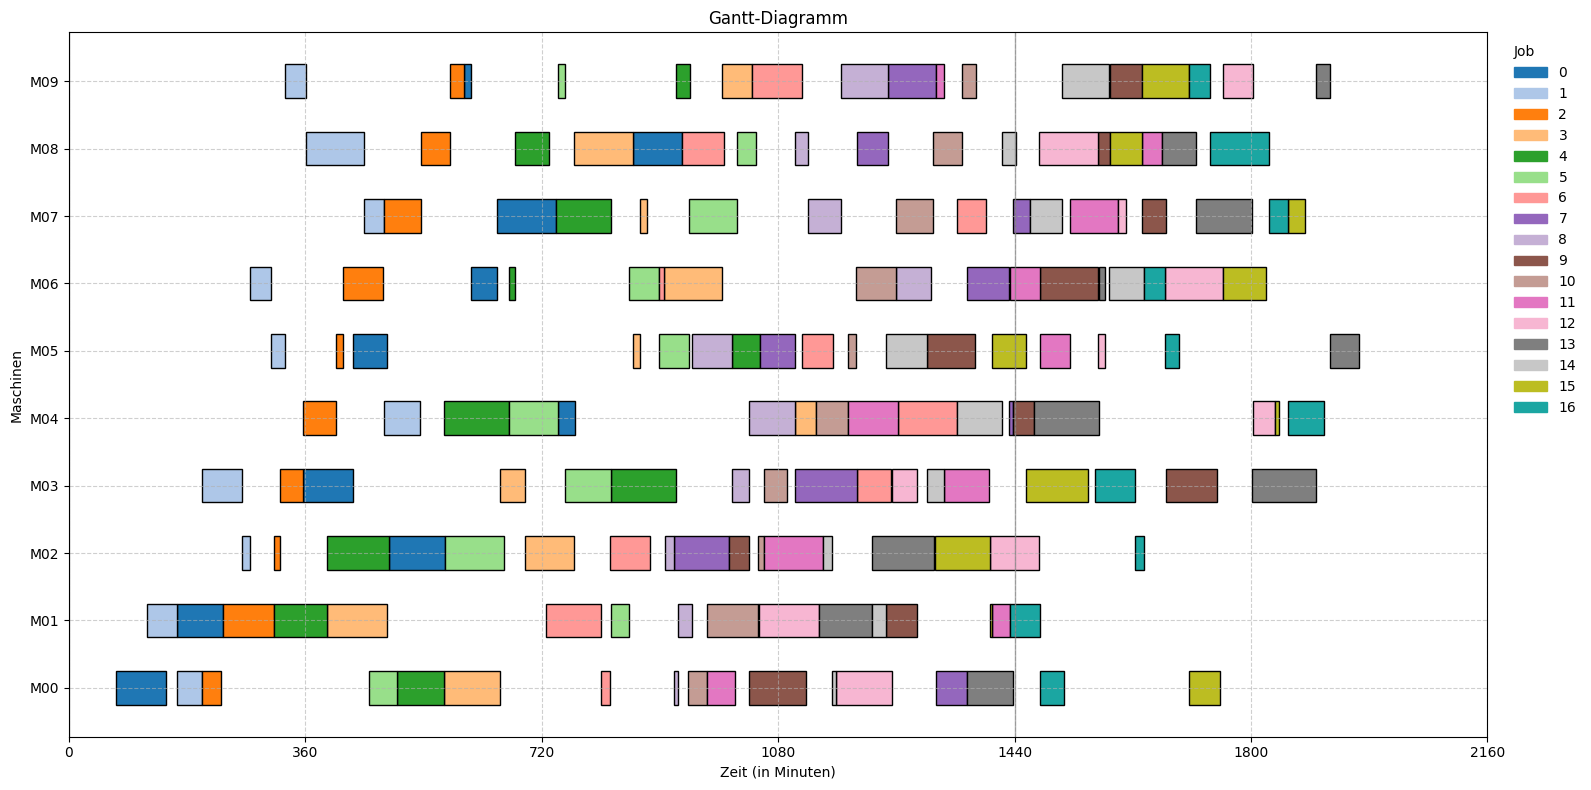

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [7]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

In [8]:
df_schedule.to_csv(basic_data_path / "schedule_example.csv", index=False)

## b) gewichtet

In [9]:
# Scheduling
df_schedule = lp_flowtime.solve_jssp_weighted_arrival(df_jssp, df_jobs_arrivals, solver= "HiGHS", var_cat="Integer", msg=False, timeLimit=max_time, gapRel= 0.05)
df_schedule

BigM: 10000

Solver-Informationen:
  Gewichtete Flow Time     : 19711.3476
  Solver-Status            : Optimal
  Anzahl Variablen         : 1547
  Anzahl Constraints       : 2890
  Laufzeit                 : ~900.33 Sekunden


,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,0,0,72,M00,72.0,76.0,76.0,148.0
1,0,1,72,M01,165.0,69.0,162.0,234.0
2,0,2,72,M03,263.0,76.0,267.0,339.0
3,0,3,72,M05,339.0,51.0,318.0,390.0
4,0,4,72,M02,390.0,85.0,403.0,475.0
...,...,...,...,...,...,...,...,...
165,16,5,1377,M05,1642.0,21.0,286.0,1663.0
166,16,6,1377,M09,1663.0,32.0,318.0,1695.0
167,16,7,1377,M08,1695.0,89.0,407.0,1784.0
168,16,8,1377,M07,1784.0,30.0,437.0,1814.0


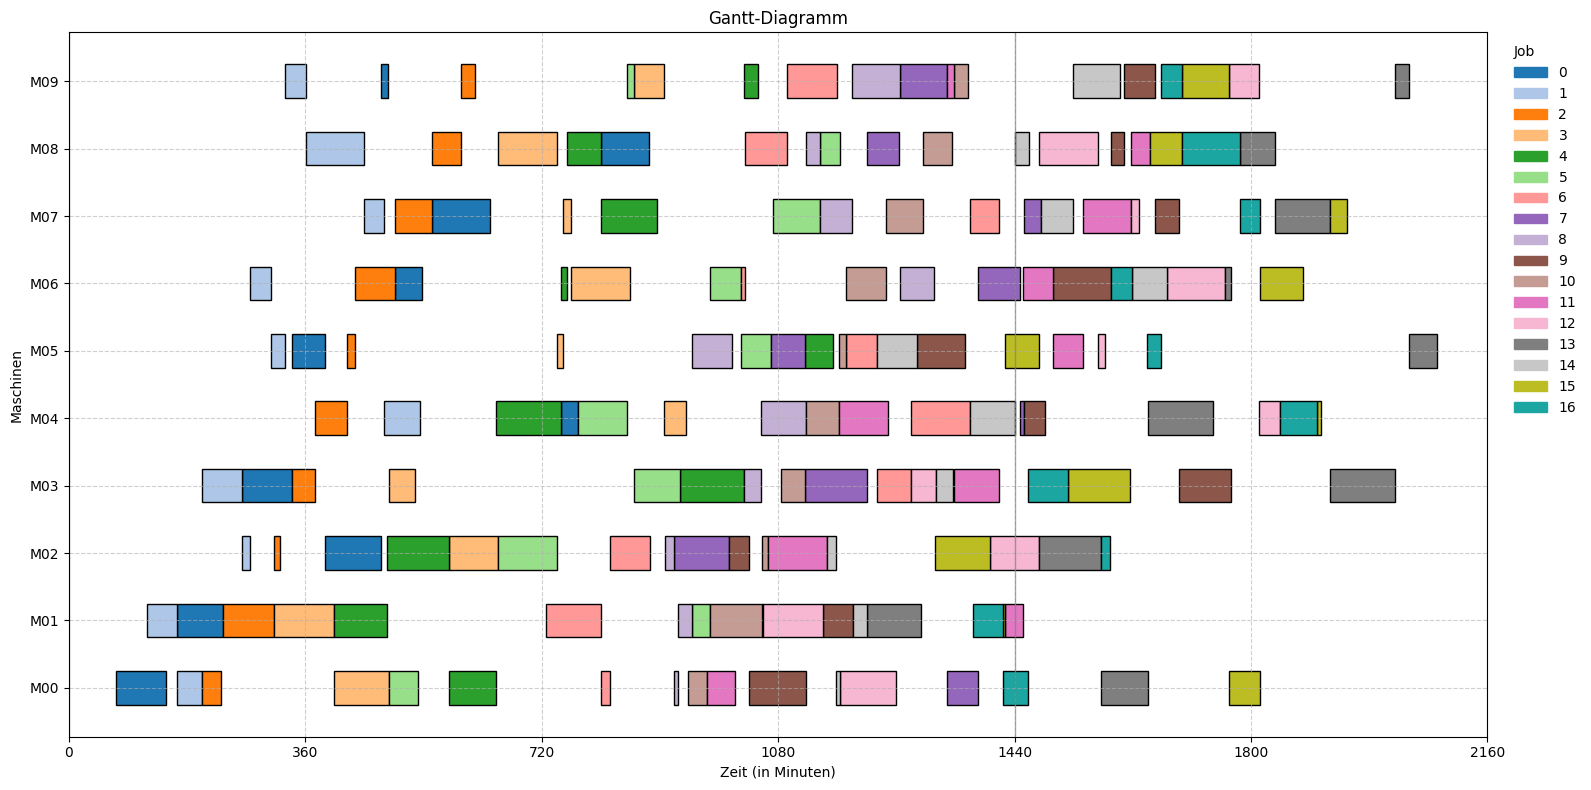

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [10]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)